In [18]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from collections import defaultdict

# Function to encode a chunk of transactions
def encode_transactions(transactions, te):
    te_ary = te.transform(transactions)
    return pd.DataFrame(te_ary, columns=te.columns_)

# Initialize TransactionEncoder
te = TransactionEncoder()

# Parameters
chunk_size = 100000  # Adjust chunk size to your system's memory limit
min_support = 0.01  # Adjust the minimum support value as needed
total_transactions = 0  # Keep track of total number of transactions
all_items_set = set()  # This will hold all unique items
selected_columns = ['Primary Type', 'Arrest', 'Domestic']

# First pass: create the set of all unique items
for chunk in pd.read_csv("Crimes_-_2001_to_Present.csv", chunksize=chunk_size):
    chunk['Arrest'] = chunk['Arrest'].apply(lambda x: 'Arrest' if x else 'No Arrest')
    chunk['Domestic'] = chunk['Domestic'].apply(lambda x: 'Domestic' if x else 'No Domestic')
    chunk = chunk.astype(str)
    transactions = chunk[selected_columns].values.tolist()
    all_items_set.update([item for sublist in transactions for item in sublist])

# Fit the TransactionEncoder to all items
te.fit([list(all_items_set)])

# Initialize dictionary to keep track of itemset support across all chunks
itemset_support_dict = defaultdict(int)

# Second pass: read the CSV file in chunks and process each chunk
for chunk in pd.read_csv("Crimes_-_2001_to_Present.csv", chunksize=chunk_size):
    chunk['Arrest'] = chunk['Arrest'].apply(lambda x: 'Arrest' if x else 'No Arrest')
    chunk['Domestic'] = chunk['Domestic'].apply(lambda x: 'Domestic' if x else 'No Domestic')
    chunk = chunk.astype(str)
    transactions = chunk[selected_columns].values.tolist()
    df_encoded = encode_transactions(transactions, te)
    chunk_frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)
    for index, row in chunk_frequent_itemsets.iterrows():
        itemset = frozenset(row['itemsets'])
        support = row['support']
        itemset_support_dict[itemset] += support * len(chunk)
    total_transactions += len(chunk)

# Convert support counts to relative support values
for itemset in itemset_support_dict.keys():
    itemset_support_dict[itemset] /= total_transactions

# Filter itemsets by global support to get the final frequent itemsets
global_frequent_itemsets = {itemset for itemset, support in itemset_support_dict.items() if support >= min_support}

# Display the global frequent itemsets
print(global_frequent_itemsets)

{frozenset({'OTHER OFFENSE', 'Domestic'}), frozenset({'No Domestic', 'BURGLARY'}), frozenset({'Arrest', 'No Domestic'}), frozenset({'ASSAULT', 'Domestic'}), frozenset({'ASSAULT', 'No Arrest', 'No Domestic'}), frozenset({'Arrest'}), frozenset({'NARCOTICS', 'Arrest'}), frozenset({'No Arrest', 'THEFT', 'No Domestic'}), frozenset({'CRIMINAL DAMAGE', 'Domestic'}), frozenset({'No Arrest', 'No Domestic'}), frozenset({'No Arrest', 'OTHER OFFENSE', 'Domestic'}), frozenset({'No Domestic'}), frozenset({'BATTERY'}), frozenset({'OTHER OFFENSE'}), frozenset({'No Domestic', 'BATTERY'}), frozenset({'MOTOR VEHICLE THEFT', 'No Domestic'}), frozenset({'NARCOTICS', 'No Domestic'}), frozenset({'No Arrest', 'OTHER OFFENSE'}), frozenset({'No Domestic', 'ROBBERY'}), frozenset({'No Arrest', 'CRIMINAL DAMAGE', 'No Domestic'}), frozenset({'Arrest', 'BATTERY'}), frozenset({'Arrest', 'No Domestic', 'WEAPONS VIOLATION'}), frozenset({'No Arrest', 'BATTERY', 'Domestic'}), frozenset({'No Arrest', 'No Domestic', 'BURGL

In [26]:
# This is for part3

import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

df = pd.read_csv("Crimes_-_2001_to_Present.csv")

# Define the columns that you consider as items for the Apriori algorithm
selected_columns = ['Primary Type', 'Arrest', 'Domestic']

# Create transactions: Each transaction is a list of items
all_transactions = df.apply(lambda x: x.tolist(), axis=1).tolist()


unique_items = {item for itemset in global_frequent_itemsets for item in itemset}


def encode_frequent_itemsets(transactions, frequent_itemsets):
    encoded_data = []
    for transaction in transactions:
        transaction_set = set(transaction)
        encoded_row = [int(itemset.issubset(transaction_set)) for itemset in frequent_itemsets]
        encoded_data.append(encoded_row)
    return np.array(encoded_data)
encoded_matrix = encode_frequent_itemsets(all_transactions, global_frequent_itemsets)

C:\Users\I17338834\AppData\Local\Temp\ipykernel_6680\1662565378.py:6: DtypeWarning: Columns (0,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Crimes_-_2001_to_Present.csv")


In [28]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce the dimensionality for visualization purposes
# can tune PCA input, can be used for part 4

pca = PCA(2)
reduced_data_2 = pca.fit_transform(encoded_matrix)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

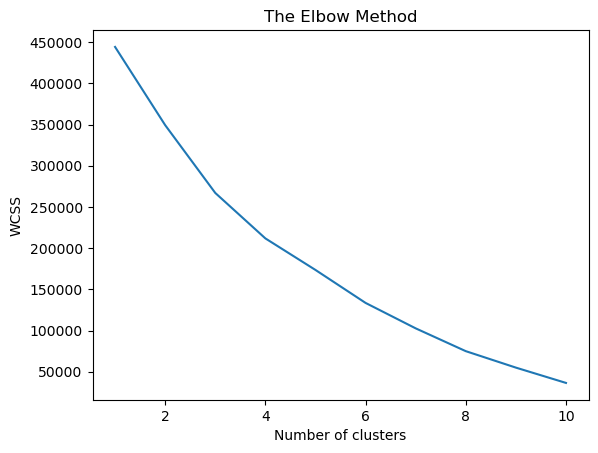

In [46]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
wcss = []
for i in range(1, 11):  # testing 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(encoded_matrix)  # encoded_matrix from your previous step
    wcss.append(kmeans.inertia_)

# Plotting the results onto a line graph to observe 'The Elbow'
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within cluster sum of squares
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


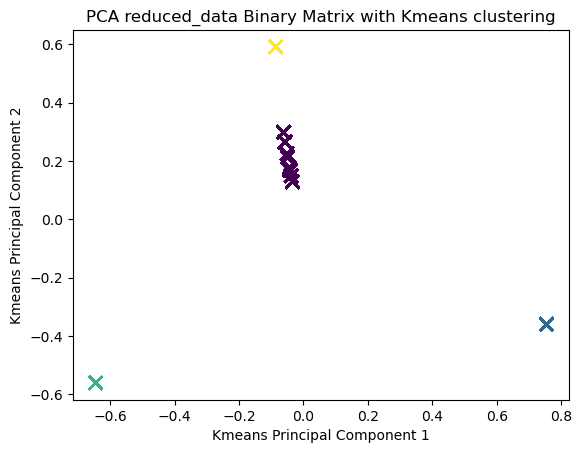

In [65]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=4, random_state=0)
kmeans_labels = kmeans.fit_predict(encoded_matrix)

plt.scatter(reduced_data_2[:, 0], reduced_data_2[:, 1], c=kmeans_labels, cmap='viridis', marker='x',s=90)
plt.title('PCA reduced_data Binary Matrix with Kmeans clustering')
plt.xlabel('Kmeans Principal Component 1')
plt.ylabel('Kmeans Principal Component 2')

plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
wcss = []
for i in range(2, 8):  # testing 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(encoded_matrix)  # encoded_matrix from your previous step
    wcss.append(kmeans.inertia_)

# Plotting the results onto a line graph to observe 'The Elbow'
plt.plot(range(2, 8), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within cluster sum of squares
plt.show()

# Calculate Silhouette Score for each number of clusters
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(encoded_matrix)
    silhouette_scores.append(silhouette_score(encoded_matrix, kmeans.labels_))

# Plotting the results
plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

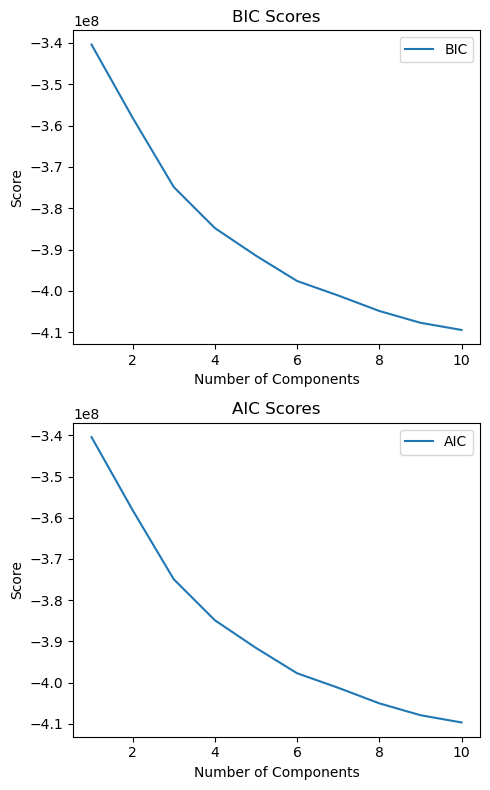

In [77]:
#GaussianMixture clustering

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'encoded_matrix' is available from the earlier step
# and is the binary matrix representing the transactions encoded with itemsets.

# Define a range of number of components to try
n_components_range = range(1, 11)

# Lists to store the BIC and AIC values
bics = []
aics = []

# Calculate BIC and AIC for each number of components
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(encoded_matrix)
    bics.append(gmm.bic(encoded_matrix))
    aics.append(gmm.aic(encoded_matrix))
    ratio.append(gmm.bic(encoded_matrix)/gmm.aic(encoded_matrix))

# Plot the BIC and AIC values
plt.figure(figsize=(5, 8))

plt.subplot(2, 1, 1)
plt.plot(n_components_range, bics, label='BIC')
plt.title('BIC Scores')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(n_components_range, aics, label='AIC')
plt.title('AIC Scores')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.legend()

# plt.subplot(2, 2, 1)
# plt.plot(n_components_range, ratio, label='Ratio of ')
# plt.title('Ratio BIC/AICScores')
# plt.xlabel('Number of Components')
# plt.ylabel('Score')
# plt.legend()

plt.tight_layout()
plt.show()

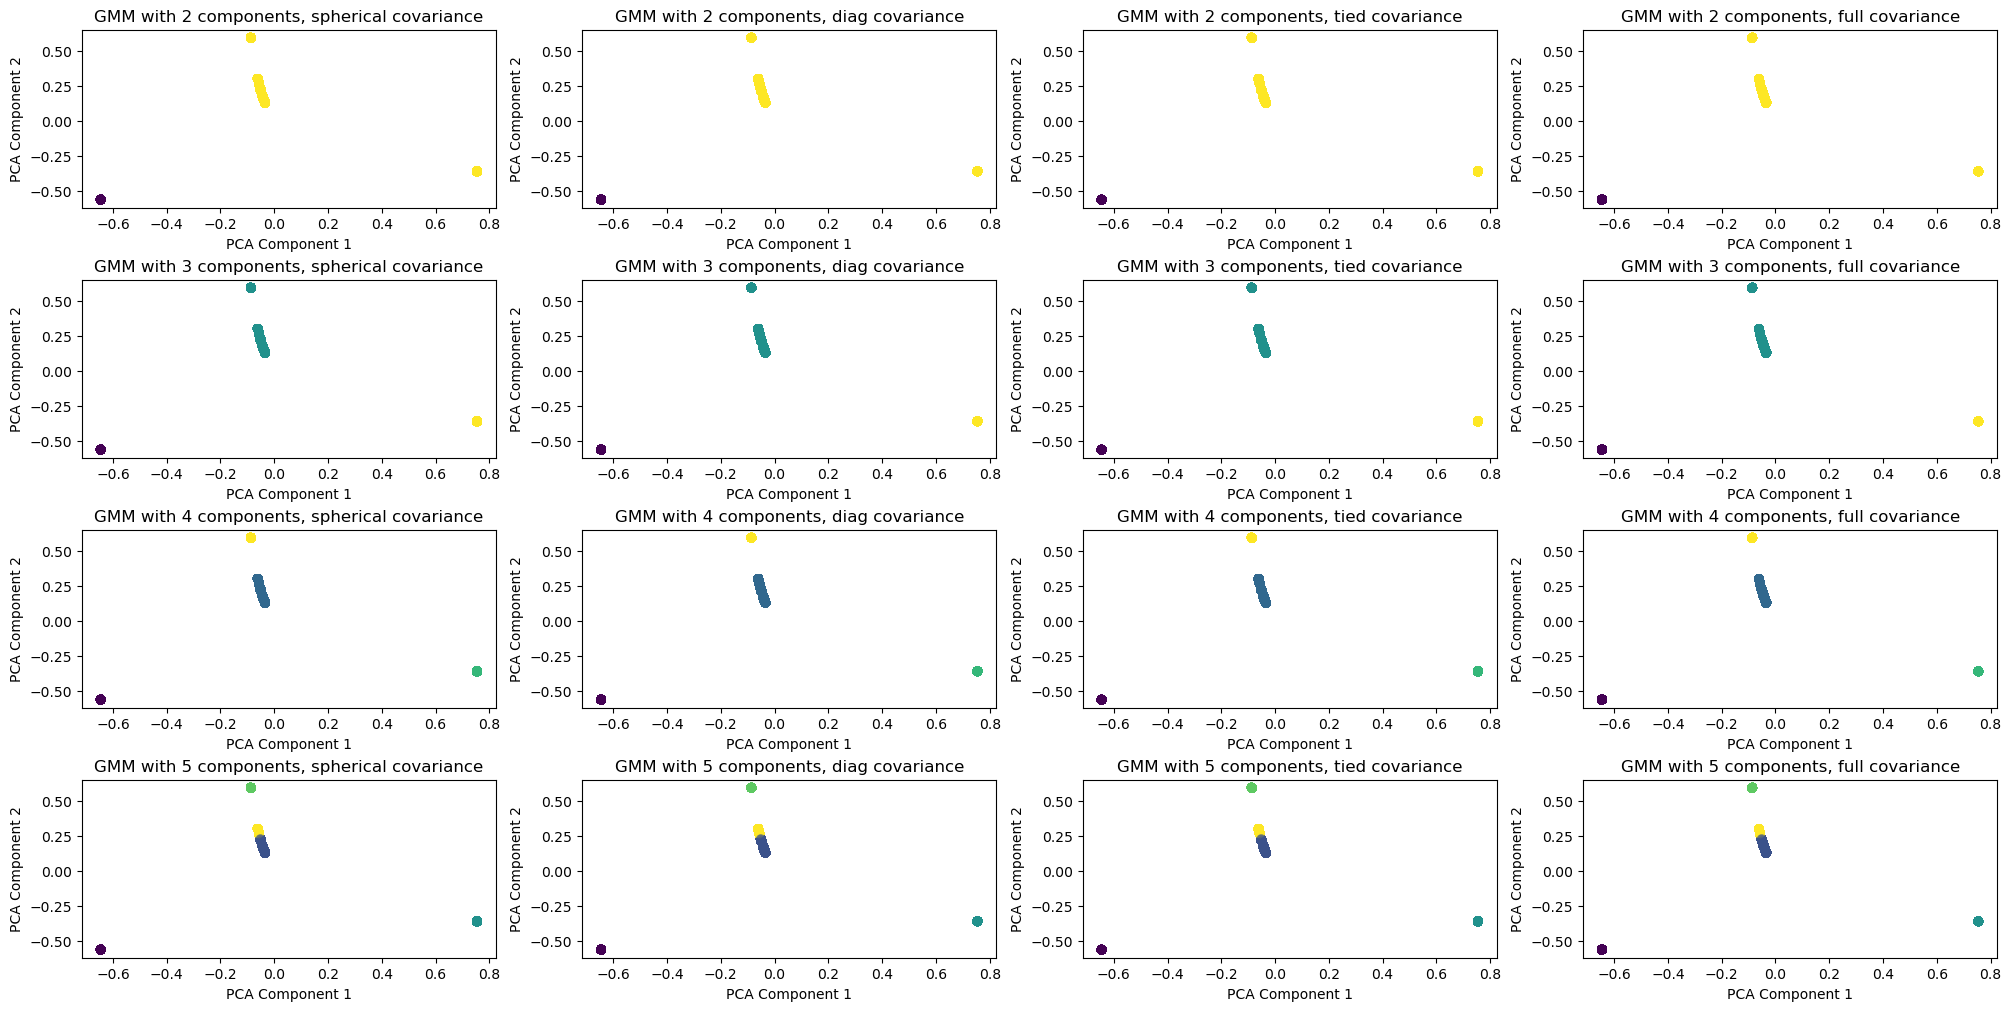

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

# Perform PCA for dimensionality reduction for a 2D scatter plot
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(encoded_matrix)

n_components_range = range(3, 6)  # Example: testing 1-7 components
covariance_types = ['spherical', 'diag', 'tied', 'full']


# Create a subplot grid
fig, axes = plt.subplots(len(n_components_range), len(covariance_types), figsize=(20, 10), constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each combination of n_components and covariance_type
for idx, (n_components, covariance_type) in enumerate([(n, cv_type) for n in n_components_range for cv_type in covariance_types]):
    # Fit a Gaussian mixture with EM
    gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=0)
    gmm.fit(reduced_data)
    gmm_labels = gmm.predict(reduced_data)

    # Plot the PCA-reduced data with GMM cluster labels
    axes[idx].scatter(reduced_data[:, 0], reduced_data[:, 1], c=gmm_labels, cmap='viridis', marker='o', alpha=0.5)
    
    # Annotate the plot with the number of components and covariance type
    axes[idx].set_title(f'GMM with {n_components} components, {covariance_type} covariance')
    axes[idx].set_xlabel('PCA Component 1')
    axes[idx].set_ylabel('PCA Component 2')

# Show the plots
plt.show()

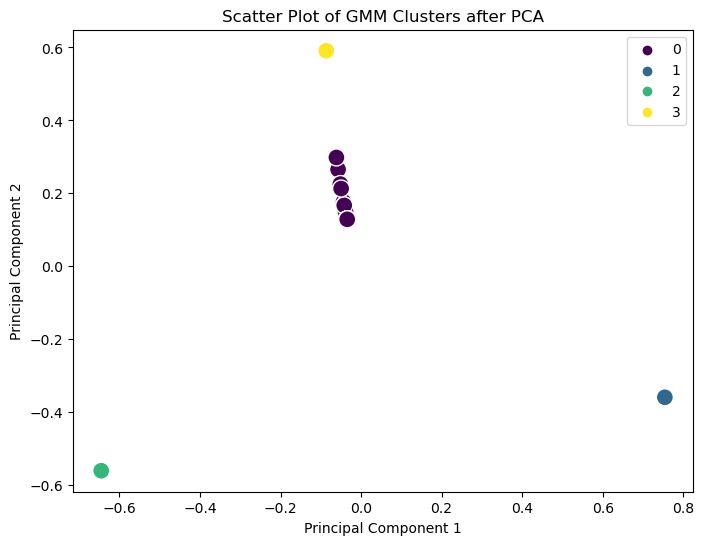

In [75]:
from sklearn.mixture import GaussianMixture

# Choose the number of components based on your previous analysis with KMeans
n_components = 4

# Initialize the GaussianMixture model
gmm = GaussianMixture(n_components=n_components, random_state=42)

# Fit the model and predict the cluster labels
gmm_labels = gmm.fit_predict(encoded_matrix)

# You can also access the probabilities that a point belongs to a cluster
probs = gmm.predict_proba(encoded_matrix)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce the dimensions to 2 for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(encoded_matrix)

# Create a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=gmm_labels, palette="viridis",s=150)
plt.title("Scatter Plot of GMM Clusters after PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()